# 动态ONNX推理量化测试

## 1. FP32精度测试 

In [1]:
import numpy as np
from PIL import Image
import cv2

def preprocess(image):
    channel_num = image.layers  #通道数

    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])),  Image.Resampling.BILINEAR)
    
    if channel_num == 1:  #灰度图像转三通道
        # print("trans")
        image = cv2.cvtColor(np.array(image) , cv2.COLOR_GRAY2RGB)
   
    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image


In [3]:
with open("../images_list.txt","r") as f:
   img_path_list =  f.readlines()
img_path_list  = [x.rstrip() for x in img_path_list]
img_path_list  #数据集路径

['/home/geng/fiftyone/coco-2017/validation/data/000000397133.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000037777.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000252219.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000087038.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000174482.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000403385.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000006818.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000480985.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000458054.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000331352.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000296649.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000386912.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000502136.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000491497.jpg',
 '/home/geng/fiftyone/coco-2017/validation/data/000000184791.j

In [ ]:
for path

In [3]:
import onnxruntime
from tqdm import tqdm

onnxruntime_model_path = "/home/geng/tinyml/ppq/benchmark/detection/FP32_model/FasterRCNN-12-FP32.onnx"
providers = ['CUDAExecutionProvider']  #临时修
sess = onnxruntime.InferenceSession(path_or_bytes=onnxruntime_model_path, providers=providers)
input_placeholder_name = sess.get_inputs()[0].name

outputs = []
for img_path in tqdm(img_path_list):
    img = Image.open(img_path)
    try:
        input_tensor = preprocess(img)
    except IndexError:
        print(f"error happend in precess {img_path}")
        break
    output = sess.run(input_feed={input_placeholder_name: input_tensor}, output_names=None)
    outputs.append({"file_name":img_path,"img_size":img.size,"output":output})
    break

  0%|          | 0/4952 [00:01<?, ?it/s]


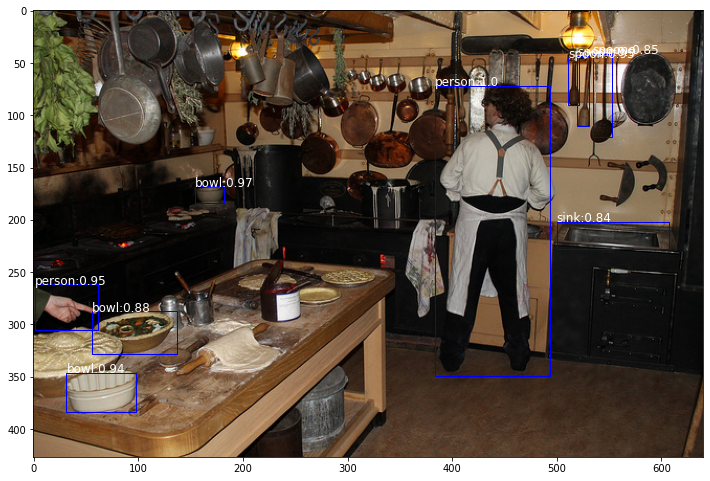

In [4]:
# 测试实际检测效果
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ..dataset import coco_classes

idx = 0
classes = coco_classes()

def display_objdetect_image(image, boxes, labels, scores, score_threshold=0.7):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    boxes /= ratio

    _, ax = plt.subplots(1, figsize=(12,9))
    image = np.array(image)
    ax.imshow(image)

    # Showing boxes with score > 0.7
    for box, label, score in zip(boxes, labels, scores):
        if score > score_threshold:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
            ax.annotate(classes[label-1] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=12)
            ax.add_patch(rect)
    plt.show()
img = Image.open(img_path_list[idx])
display_objdetect_image(img, *outputs[idx]["output"])

In [5]:
import torch
class_num = 80

results = []
for output in tqdm(outputs):
    bboxs,labels,scores = output["output"]
    result = [[] for _ in range(class_num)]
    ratio = 800.0 / min(output["img_size"][0], output["img_size"][1])
    bboxs /= ratio
    
    bboxs = torch.cat((torch.from_numpy(bboxs),torch.from_numpy(scores.reshape((-1,1)))),dim=1)
    for i,label in enumerate(labels):
        result[label-1].append(bboxs[i])
    results.append(result)

100%|██████████| 4952/4952 [00:02<00:00, 2184.16it/s]


In [6]:
from dataset import build_dataset
ann_file = "/home/geng/fiftyone/coco-2017/validation/labels.json"
data_root = '/home/geng/fiftyone/coco-2017/validation/data/'  # 数据的根路径。
batch_size = 1
input_size = (480,640)  #或者 (1,3,480,640)

# 数据加载
dataset = build_dataset(ann_file=ann_file,data_root=data_root,input_size=input_size)
dataset.results2json(results=results,outfile_prefix="/home/geng/tinyml/ppq/benchmark/detection/FP32_model/FasterRCNN-12-FP32") #也可以将推理结果持久化

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!


{'bbox': '/home/geng/tinyml/ppq/benchmark/detection/FP32_model/FasterRCNN-12-FP32.bbox.json',
 'proposal': '/home/geng/tinyml/ppq/benchmark/detection/FP32_model/FasterRCNN-12-FP32.bbox.json'}

In [7]:
# dataset.evaluate(results=results) 
dataset.evaluate(results_json_path="/home/geng/tinyml/ppq/benchmark/detection/FP32_model/FasterRCNN-12-FP32.bbox.json") 


Evaluating bbox...
Loading and preparing results...
DONE (t=0.86s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=66.03s).
Accumulating evaluation results...
DONE (t=13.37s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox_mAP', 0.352),
             ('bbox_mAP_50', 0.578),
             ('bbox_mAP_75', 0.373),
             ('bbox_mAP_s', 0.185),
             ('bbox_mAP_m', 0.387),
             ('bbox_mAP_l', 0.473),
             ('bbox_mAP_copypaste', '0.352 0.578 0.373 0.185 0.387 0.473')])